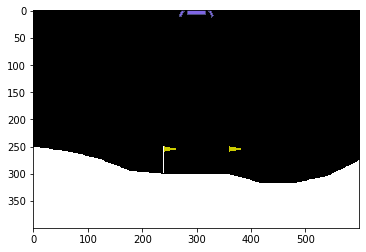

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLander-v2") #env

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [2]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(32, 64, 32),
                      activation='relu',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=2,  # make only 1 iteration on each .fit(...)
                      learning_rate_init=0.01
                      )
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/arsen/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 64, 32), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=2, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [3]:
def generate_session(t_max=10000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(n_actions,p=probs) #<sample action with such probabilities >

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [4]:
import itertools

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    reward_threshold =np.percentile(rewards_batch,q=percentile) # <Compute minimum reward for elite sessions. Hint: use np.percentile >
    actions_batch=np.asarray(actions_batch)
    states_batch=np.asarray(states_batch)
    elite_states = states_batch[rewards_batch>reward_threshold]#<your code here >
    elite_actions = actions_batch[rewards_batch>reward_threshold]#<your code here >
    elite_states = list(elite_states)
    elite_actions = list(elite_actions)
    return list(itertools.chain(*elite_states)), list(itertools.chain(*elite_actions))

In [5]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, reward_range=[-15000, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 54.232, threshold=86.458


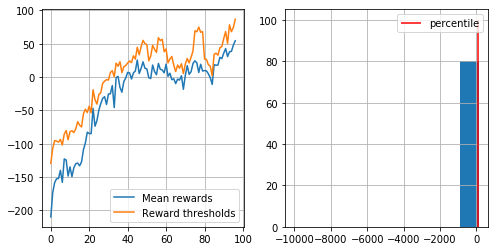

54.23215371884386
You Win! You may stop training now via KeyboardInterrupt.


In [6]:
n_sessions = 80
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for j in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch,percentile)#<select elite actions just like before >
    print(len(elite_states),len(elite_actions))
    agent.fit(elite_states,elite_actions) #<fit agent to predict elite_actions(y) from elite_states(X) >

    show_progress(rewards_batch, log, reward_range=[-10000, np.max(rewards_batch)])
    print(np.mean(rewards_batch))
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break